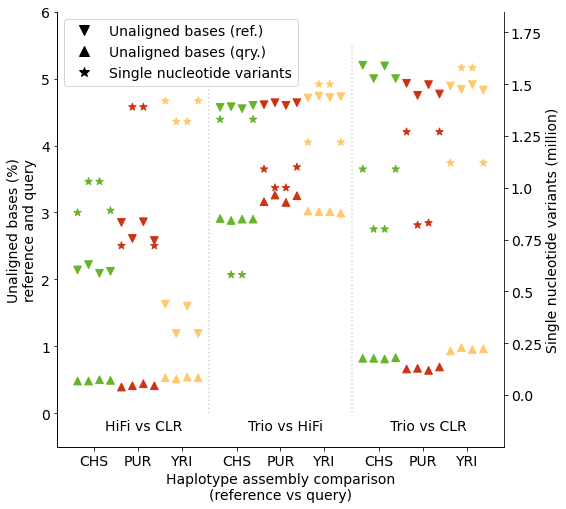

In [4]:
import os
import collections as col
import importlib

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()
prop = plot_aux.get_plot_property

save_plots = True
print_stats = False

pipeline_version = 'v12'

stats_path = '/home/local/work/data/hgsvc/figSX_panels/tech_comp'
out_path = os.path.join(stats_path, pipeline_version, 'figSX_panel_tech_comparison')
cache_file = os.path.join(stats_path, 'cache_{}.h5'.format(pipeline_version))

def parse_num_values(value):
    
    if '%' in value:
        count, pct = value.strip('%)').split('(')
        count = int(count)
        pct = float(pct)
    elif '.' in value:
        count = None
        pct = float(value)
    else:
        count = int(value)
        pct = None
    return count, pct
  

def load_comparison_stats(file_path):
    
    row_values = dict()
    section_prefix = None
    with open(file_path, 'r') as listing:
        # skip header lines
        _ = listing.readline()
        _ = listing.readline()
        for line in listing:
            if not line.strip():
                continue
            infos = [v for v in line.strip().split() if v]
            if infos[0] == '[REF]':
                continue
            elif infos[0].startswith('['):
                section_prefix = infos[0].strip('[]')
                continue
            else:
                header = infos[0]
                header = header.replace('-', '_')
                header = header.replace('.', 'gap')
                header = section_prefix + '_' + header
                for prefix, value in zip(['REF', 'QRY'], infos[1:]):
                    count, pct = parse_num_values(value)
                    if count is not None:
                        row_values[prefix + '_' + header + '_count'] = count
                    if pct is not None:
                        row_values[prefix + '_' + header + '_pct'] = pct
    return row_values

def normalize_haplotype(hap):
    
    if hap == 'h1-un' or 'hapA':
        h = 10
    elif hap == 'h2-un' or 'hapB':
        h = 20
    else:
        raise ValueError('unknown haplotype: {}'.format(hap))
    return h


def extract_index_info(file_path):
    
    ref_assm, qry_assm = os.path.basename(file_path).strip('.report').split('_vs_')
    sample, ref_assm = ref_assm.split('_', 1)
    ref_platform, ref_hap = ref_assm.split('-', 1)
    qry_platform, qry_hap = qry_assm.split('-', 1)
    ref_hap = normalize_haplotype(ref_hap)
    qry_hap = normalize_haplotype(qry_hap)
    super_pop = samples[sample]['super_population']
    pop = samples[sample]['population']
    return sample, super_pop, pop, ref_platform, ref_hap, qry_platform, qry_hap


if not os.path.isfile(cache_file):
    stat_files = plot_aux.load_plot_data_files(
        stats_path,
        '.report',
        pipeline_version)
    plot_data = [load_comparison_stats(fp) for fp in stat_files]
    
    row_indices = [extract_index_info(fp) for fp in stat_files]

    df = pd.DataFrame(
        plot_data,
        columns=sorted(plot_data[0].keys()),
        index=row_indices
    )

    df.index = pd.MultiIndex.from_tuples(
        df.index.values,
        names=['sample', 'super_pop', 'pop', 'ref_assembly', 'ref_hap', 'qry_assembly', 'qry_hap']
    )
    df.to_hdf(cache_file, key='cache', mode='w', format='fixed')
    
df = pd.read_hdf(cache_file, 'cache')
df.sort_index(
    axis=0,
    inplace=True,
    level=['sample', 'super_pop', 'pop', 'ref_assembly', 'qry_assembly', 'ref_hap', 'qry_hap'])

    
def plot_assembly_contiguity(sample_stats):
        
    x_vals = [0]
    x_label_locs = []
    group_labels = col.defaultdict(list)
    group_separators = []
    
    y_unaln_ref = []
    y_unaln_qry = []
    y_snv = []
    
    colors = []
    
    comparisons = [
        ('HiFi', 'CLR'),
        ('Trio', 'HiFi'),
        ('Trio', 'CLR')
    ]
    
    for ref, qry in comparisons:
    
        subset = sample_stats.xs([ref, qry], level=['ref_assembly', 'qry_assembly'])
        sep = max(x_vals) + 1
        if sep > 1:
            group_separators.append(sep)
        for loc, (idx, row) in enumerate(subset.iterrows(), start=max(x_vals) + 2):
            sample = idx[0]
            population = idx[2]
            colors.append(rgbcodes[population])

            ref_hap = 'H' + str(idx[3]).strip('0')
            qry_hap = 'H' + str(idx[4]).strip('0')
            x_vals.append(loc)
            #x_label_locs.append((loc, '{} / {}'.format(ref_hap, qry_hap)))
            group_labels[(sample, ref, qry)].append(loc)

            y_unaln_ref.append(row.REF_Bases_UnalignedBases_pct)
            y_unaln_qry.append(row.QRY_Bases_UnalignedBases_pct)
            y_snv.append(round(row.REF_SNPs_TotalGSNPs_count / 1e6, 2))
    
    # drop zero from x_values
    x_vals = x_vals[1:]
    
    # compute group / comparison label position
    comp_labels = []
    for key, positions in group_labels.items():
        label = '{}'.format(samples[key[0]]['population'])
        label_pos = round((min(positions) + max(positions)) / 2, 1)
        x_label_locs.append((label_pos, label))
        if key[0] == 'HG00514':
            comp_labels.append((label_pos, '{} vs {}'.format(key[1], key[2])))
        
    x_label_locs = sorted(x_label_locs)
    x_labels = [t[1] for t in x_label_locs]
    x_label_pos = [t[0] for t in x_label_locs]
    
    fig, axis = plt.subplots(figsize=(8,8))

    axis.scatter(
        x_vals,
        y_unaln_ref,
        s=prop('plot_marker_size'),
        c=colors,
        marker='v'
    )
    
    axis.scatter(
        x_vals,
        y_unaln_qry,
        s=prop('plot_marker_size'),
        c=colors,
        marker='^'
    )

    # make second y-axis
    y_axis_snv = axis.twinx()
    
    y_axis_snv.scatter(
        x_vals,
        y_snv,
        s=prop('plot_marker_size'),
        c=colors,
        marker='*'

    
    )
    
    axis.vlines(
        group_separators,
        0,
        5.5,
        color='lightgrey',
        linestyles='dotted',
        
    )
    
    axis.set_xticks(
        x_label_pos
    )
    axis.set_xticklabels(
        x_labels
    )
    
    axis.set_xlabel(
        'Haplotype assembly comparison\n(reference vs query)',
        fontsize=prop('fontsize_legend')
    )
    axis.set_ylabel(
        'Unaligned bases (%)\nreference and query',
        fontsize=prop('fontsize_legend')
    )
    y_axis_snv.set_ylabel(
        'Single nucleotide variants (million)',
        fontsize=prop('fontsize_legend')
    )
    
    for x, text in comp_labels:
        axis.text(x + 1, -0.25, text, fontdict={'size': 14})
    
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.set_ylim(-0.5, 6)
    y_axis_snv.set_ylim(-0.25, 1.85)
    y_snv_ticks = np.arange(0, 2, step=0.25)
    y_axis_snv.set_yticks(y_snv_ticks)
    y_axis_snv.set_yticklabels(map(str, y_snv_ticks))
    
    y_axis_snv.spines['top'].set_visible(False)
    
    axis.tick_params(
        axis='both',
        which='major',
        labelsize=prop('fontsize_axis_ticks')
    )

    y_axis_snv.tick_params(
        axis='both',
        which='major',
        labelsize=prop('fontsize_axis_ticks')
    )
    
    # build custom legend
    custom_lines = [
        lines.Line2D(
            [0], [0],
            color='black',
            markersize=prop('legend_marker_size'),
            marker='v',
            ls='None',
            label='Unaligned bases (ref.)'
        ),
        lines.Line2D(
            [0], [0],
            color='black',
            markersize=prop('legend_marker_size'),
            marker='^',
            ls='None',
            label='Unaligned bases (qry.)'
        ),
        lines.Line2D(
            [0], [0],
            color='black',
            markersize=prop('legend_marker_size'),
            marker='*',
            ls='None',
            label='Single nucleotide variants'
        )   
    ]
    
    axis.legend(
        handles=custom_lines,
        loc='upper left',
        prop={'size': prop('fontsize_legend')}
    )

#     if missing:
#         plot_aux.add_incomplete_stamp(axis, 0.5, 0.85)
    
    extra_artists = []
    
    return fig, extra_artists
        
fig, exart = plot_assembly_contiguity(df)

if save_plots:
    fig.savefig(
        out_path + '_lowres.png',
        dpi=prop('dpi_low_res'),
        bbox_inches='tight',
        extra_artists=exart
    )
    
    fig.savefig(
        out_path + '.png',
        dpi=prop('dpi_high_res'),
        bbox_inches='tight',
        extra_artists=exart
    )
    
    fig.savefig(out_path + '.svg', bbox_inches='tight', extra_artists=exart)
